<font size="6">Lesson 10: Convolutional Neural Networks</font>

Readings:
- [Deep learning, section 9](http://www.deeplearningbook.org/contents/convnets.html)
- [A Comprehensive Guide to Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
- [視覚野と畳み込みニューラルネットワーク](https://lp-tech.net/articles/frQNo)

In [8]:
# import what you need
import warnings
warnings.filterwarnings("ignore")
from PIL import Image 
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms

--- 

<font size="5">Overviews</font>
1. Introduction
1. Motivations
    1. Sparse interactions
    1. Parameter sharing
    1. Equivariant representations
1. Implementation in PyTorch
1. Summary

In [ ]:
FCC
parameter, time, Grad-CAM, feature

--- 

# Introduction
In this notebook, I'm going to explain the motivations of (Convolutional Neural Networks)CNN 
and the implementation of it.
This notebook goes subject to the understanding of basic, computation procedure, pooling layer, and batch normalization.
I will introduce 3 main motivations and confirm it with a simple example.
And in the implementation section, I will show how to implement the CNN and compare it with FCC.


---

# Motivations
**Sparse interactions**, **parameter sharing** and **equivariant representations** are 
characteristics of the CNN which is important for the machine learning model to learn efficiently.

## Sparse interactions

## Parameter sharing

In [26]:
def generate_edge_filter(vertical=True, device="cpu", nch=3):
    edge_filter = nn.Conv2d(nch, nch, 3, 1, 1)
    parameters = edge_filter.state_dict()
    bias = torch.zeros(parameters["bias"].shape)
    parameters["bias"] = bias
    weight = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    if not vertical:
        weight = weight.T
    weight = np.tile(np.reshape(weight, (1,1,3,3)), (nch,nch,1,1))
    parameters["weight"] = torch.tensor(weight)
    edge_filter.load_state_dict(parameters)
    return edge_filter.to(device)

In [55]:
def min_max(x):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min+1e-8)
    return result

In [49]:
def image_from_output(output):
    image_list = []
    output = output.detach().to("cpu").numpy()
    for i in range(output.shape[0]):
        a = output[i]
        a = np.tile(np.transpose(a, axes=(1,2,0)), (1,1,int(3/a.shape[0])))
        a = min_max(a)*2**8 
        a[a>255] = 255
        a = np.uint8(a)
        a = Image.fromarray(a)
        image_list.append(a)
    return image_list

In [50]:
img = Image.open("./implements_10/Minami_Hoshino.jpg").crop((132, 0, 900, 768)).resize((512, 512))
img = img.convert("RGB")
image = transforms.ToTensor()(img).view(1, 3, 512, 512)

In [51]:
vertical_filter = generate_edge_filter(vertical=True)

In [54]:
vertical_filter

Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

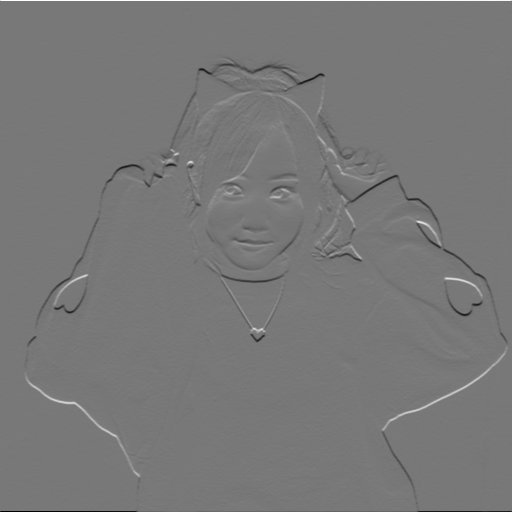

In [53]:
image_from_output(vertical_filter(image))[0]

## Equivariant representations